# Introduction

__Data Source:__

Agriculture sensor data from Easy IOT

__Goal:__
* Exploratory analysis on the data
* Prototype different ananomly detection models
* Protogype different time series models

In [72]:
from itertools import izip, count
import matplotlib.pyplot as plt
from numpy import linspace, loadtxt, ones, convolve
import numpy as np
import pandas as pd
import collections
from random import randint
from matplotlib import style
import seaborn as sns
from __future__ import absolute_import, division, print_function

import sys
import os

# TSA from Statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

import itertools
import warnings
style.use('fivethirtyeight')
%matplotlib inline

# EDA

In [3]:
data = pd.read_excel('Easy-IoT_sample.xls')
print data.shape
data.head()

(156, 6)


,device,noderssi,battery,temp,rh,timestamp
0,ABC101,-52,3.17 V,8.21,73.00,2018-04-20T06:48:02Z
1,ABC101,-39,3.17 V,7.90,75.00,2018-04-20T07:19:36Z
2,ABC101,-39,3.17 V,7.74,75.99,2018-04-20T07:51:12Z
3,ABC101,-39,3.17 V,6.88,80.00,2018-04-20T08:22:49Z
4,ABC101,-39,3.17 V,6.37,81.99,2018-04-20T08:54:29Z


In [5]:
data.describe()

,noderssi,temp,rh
count,156.000000,156.000000,156.000000
mean,-45.397436,18.041923,60.380769
std,4.223864,10.713520,25.390063
min,-65.000000,4.500000,8.000000
25%,-47.000000,10.390000,39.750000
50%,-44.000000,14.405000,66.490000
75%,-43.000000,23.435000,83.000000
max,-39.000000,51.660000,96.000000


In [6]:
data.timestamp = pd.to_datetime(data.timestamp)
data.head()

,device,noderssi,battery,temp,rh,timestamp
0,ABC101,-52,3.17 V,8.21,73.00,2018-04-20 06:48:02
1,ABC101,-39,3.17 V,7.90,75.00,2018-04-20 07:19:36
2,ABC101,-39,3.17 V,7.74,75.99,2018-04-20 07:51:12
3,ABC101,-39,3.17 V,6.88,80.00,2018-04-20 08:22:49
4,ABC101,-39,3.17 V,6.37,81.99,2018-04-20 08:54:29


In [7]:
data = data.sort_values(by='timestamp')
data.head()

,device,noderssi,battery,temp,rh,timestamp
0,ABC101,-52,3.17 V,8.21,73.00,2018-04-20 06:48:02
1,ABC101,-39,3.17 V,7.90,75.00,2018-04-20 07:19:36
2,ABC101,-39,3.17 V,7.74,75.99,2018-04-20 07:51:12
3,ABC101,-39,3.17 V,6.88,80.00,2018-04-20 08:22:49
4,ABC101,-39,3.17 V,6.37,81.99,2018-04-20 08:54:29


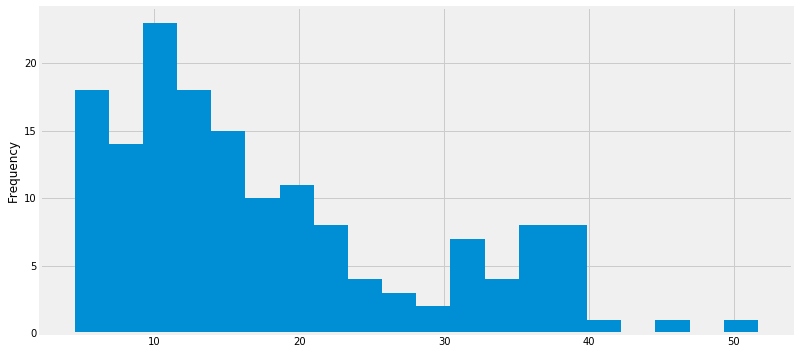

In [22]:
data['temp'].plot(kind = 'hist', figsize=(12, 6), bins=20)

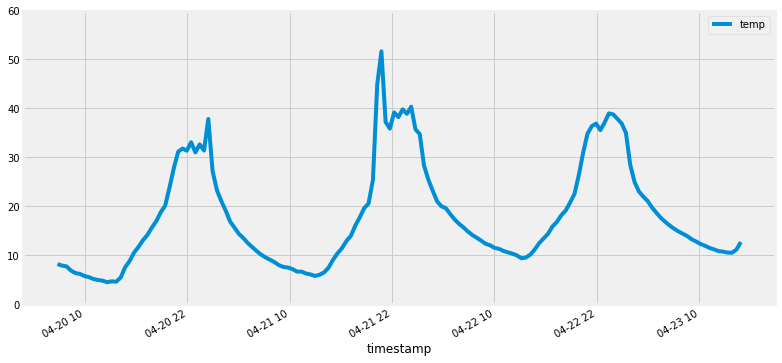

In [9]:
data.plot(x = 'timestamp', y = 'temp', figsize = (12, 6), ylim=(0, 60))

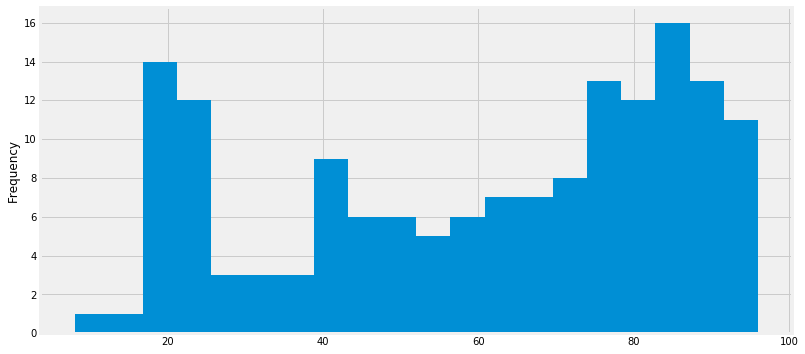

In [23]:
data['rh'].plot(kind = 'hist', figsize=(12, 6), bins=20)

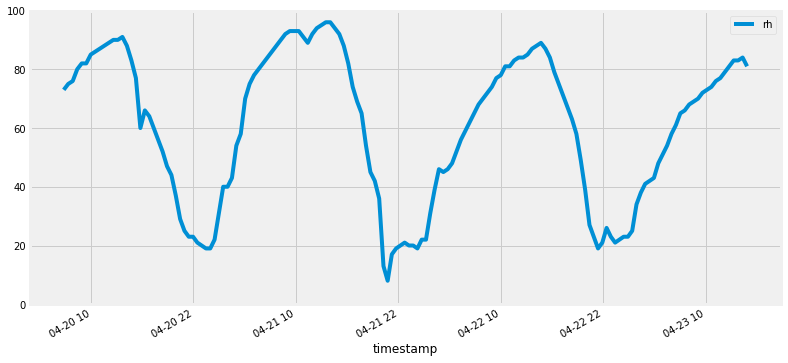

In [10]:
data.plot(x = 'timestamp', y = 'rh', figsize = (12, 6), ylim = (0, 100))

# Anomalies for temp and RH

## Method 1. Using moving average

** Helper Function **

In [11]:
def moving_avg(data, window_size):
    """ Computes moving average using discrete linear convolution of two one dimensional sequences.
    Args:
    -----
            data (pandas.Series): independent variable
            window_size (int): rolling window size

    Returns:
    --------
            ndarray of linear convolution

    References:
    ------------
    [1] Wikipedia, "Convolution", http://en.wikipedia.org/wiki/Convolution.
    [2] API Reference: https://docs.scipy.org/doc/numpy/reference/generated/numpy.convolve.html

    """  
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(data, window, 'same')

def explain_anomalies(y, window_size, sigma = 1.0):
    """ Helps in exploring the anamolies using stationary standard deviation
    Args:
    -----
        y (pandas.Series): independent variable
        window_size (int): rolling window size
        sigma (int): value for standard deviation

    Returns:
    --------
        a dict (dict of 'standard_deviation': int, 'anomalies_dict': (index: value))
        containing information about the points indentified as anomalies
    
    """
    avg = moving_avg(y, window_size).tolist()
    residual = y - avg
    std = np.std(residual)
    return {'standard_deviation': round(std, 3),
            'anomalies_dict': collections.OrderedDict([(index, y_i) for index, y_i, avg_i in izip(count(), y, avg)
                                                      if (y_i > avg_i + (sigma*std)) | (y_i < avg_i - (sigma*std))])}

def explain_anomalies_rolling_std(y, window_size, sigma=1.0):
    """ Helps in exploring the anamolies using rolling standard deviation
    Args:
    -----
        y (pandas.Series): independent variable
        window_size (int): rolling window size
        sigma (int): value for standard deviation

    Returns:
    --------
        a dict (dict of 'standard_deviation': int, 'anomalies_dict': (index: value))
        containing information about the points indentified as anomalies
    """
    avg = moving_avg(y, window_size)
    avg_list = avg.tolist()
    residual = y - avg
    # Calculate the variation in the distribution of the residual
    testing_std = pd.rolling_std(residual, window_size)
    testing_std_as_df = pd.DataFrame(testing_std)
    rolling_std = testing_std_as_df.replace(np.nan,
                                  testing_std_as_df[window_size - 1]).round(3).iloc[:,0].tolist()
    std = np.std(residual)
    return {'stationary_standard_deviation': round(std, 3),
            'anomalies_dict': collections.OrderedDict([(index, y_i)
                                                       for index, y_i, avg_i, rs_i in izip(count(),
                                                                                           y, avg_list, rolling_std)
              if (y_i > avg_i + (sigma * rs_i)) | (y_i < avg_i - (sigma * rs_i))])}

# This function is repsonsible for displaying how the function performs on the given dataset.
def plot_results(x, y, window_size, sigma_value=1,
                 text_xlabel="X Axis", text_ylabel="Y Axis", applying_rolling_std=False):
    """ Helps in generating the plot and flagging the anamolies.
        Supports both moving and stationary standard deviation. Use the 'applying_rolling_std' to switch
        between the two.
    Args:
    -----
        x (pandas.Series): dependent variable
        y (pandas.Series): independent variable
        window_size (int): rolling window size
        sigma_value (int): value for standard deviation
        text_xlabel (str): label for annotating the X Axis
        text_ylabel (str): label for annotatin the Y Axis
        applying_rolling_std (boolean): True/False for using rolling vs stationary standard deviation
    """
    plt.figure(figsize=(15, 8))
    plt.plot(x, y, "k.")
    y_av = moving_avg(y, window_size)
    plt.plot(x, y_av, color='green')
    plt.xlabel(text_xlabel)
    plt.ylabel(text_ylabel)

    # Query for the anomalies and plot the same
    events = {}
    if applying_rolling_std:
        events = explain_anomalies_rolling_std(y, window_size=window_size, sigma=sigma_value)
    else:
        events = explain_anomalies(y, window_size=window_size, sigma=sigma_value)

    x_anomaly = np.fromiter(events['anomalies_dict'].iterkeys(), dtype=int, count=len(events['anomalies_dict']))
    y_anomaly = np.fromiter(events['anomalies_dict'].itervalues(), dtype=float,
                                            count=len(events['anomalies_dict']))
    plt.plot(x_anomaly, y_anomaly, "r*", markersize=12)

    # add grid and lines and enable the plot
    plt.grid(True)
    plt.show()

In [12]:
temp_ts = data.loc[:, ['temp']]

In [13]:
temp_ts = temp_ts.reset_index()
temp_ts['index'] = temp_ts.index
temp_ts.head()

,index,temp
0,0,8.21
1,1,7.90
2,2,7.74
3,3,6.88
4,4,6.37


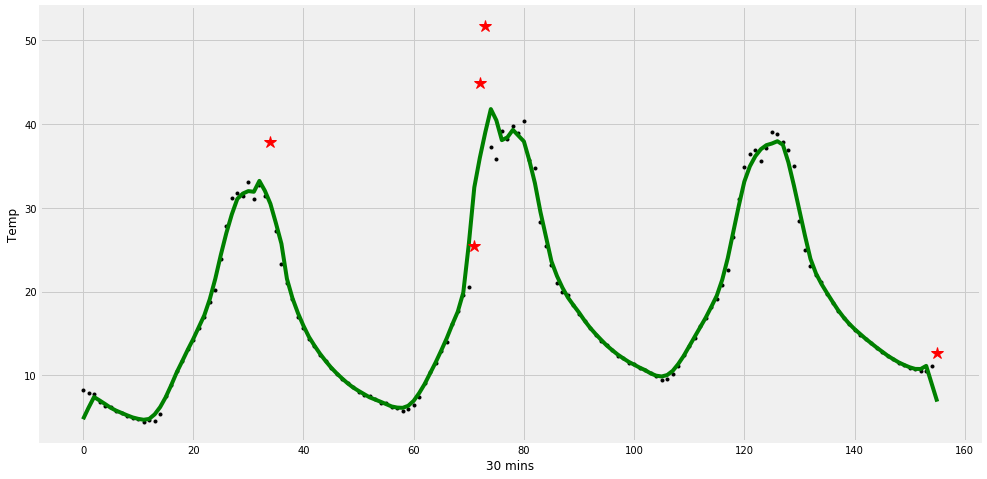

In [14]:
plot_results(x = temp_ts.index, y = temp_ts.temp, window_size=5, 
             text_xlabel = "30 mins", sigma_value = 3, text_ylabel = "Temp" )

In [15]:
rh_ts = data.loc[:, ['rh']]
rh_ts = rh_ts.reset_index()
rh_ts['index'] = rh_ts.index
rh_ts.head()

,index,rh
0,0,73.00
1,1,75.00
2,2,75.99
3,3,80.00
4,4,81.99


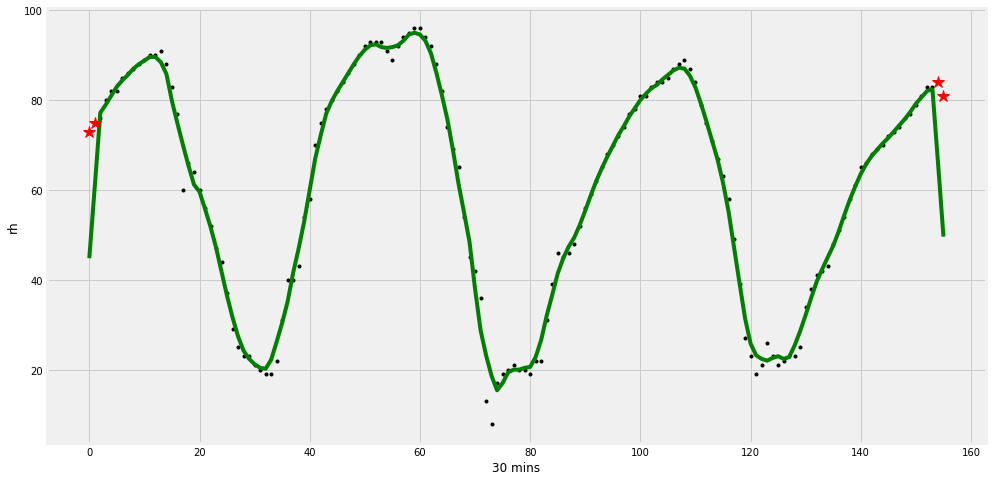

In [16]:
plot_results(x = rh_ts.index, y = rh_ts.rh, window_size=5, 
             text_xlabel = "30 mins", sigma_value = 3, text_ylabel = "rh" )

# ARIMA or SARIMA Model

Common ARIMA/SARIMA Model Exploration Steps:

* Are there any trend, seasonality, cycles?
* What are pattern of the ACF? Does it decline exponentially or dampen towards zero? Does it have a sharp cut-off?
* What about the PACF?
* model identification

** Model identification **

1. Determine the *degree of differencing*, $d$

2. Study the patterns of the ACF and PACF of the appropriately differenced series: $\omega_t = (1-B)^d z_t$, as these autocorrelation functions will provide indication for the choice of the order of autoregressive and the moving average components.  While we did not have enough time in this tutorial, it is very beneficial to study the *theoretical* ACF and PACF of the autoregressive, moving average, and the mixed autoregressive and moving average processes.

3. The table below summarize the patterns of the ACF and PACF associated with the $AR(p)$, $MA(q)$, and $ARMA(p,q)$ processes:

|  Process      |          ACF         |          PACF        |
|---------------|:--------------------:|:--------------------:|
| **AR(p)**     |    tails off         | cutoff after lag $p$ |
| **MA(q)**     | cutoff after lag $q$ |    tails off         |
| **ARMA(p,q)** |    tails off         |    tails off         |

4. In general, the ACF of an autoregressive process is similar to the PACF of a moving average process, and vice versa.
5. In practice, the estimated sample ACF and PACF can come with large variances, deviating from the underlying theoretical behavior. As such, it is prudent to recognize that these are  but broad characteristics, and it is quite possible that several candidate models are narrowed down and will need to be investigaged further in the later stage of the modeling process.


** Helper Functions **

In [53]:
def tsplot(y, lags=None, title='', figsize=(14, 8)):
    '''Examine the patterns of ACF and PACF, along with the time series plot and histogram.
    
    Original source: https://tomaugspurger.github.io/modern-7-timeseries.html
    '''
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax   = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax  = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    
    y.plot(ax=ts_ax)
    ts_ax.set_title(title)
    y.plot(ax=hist_ax, kind='hist', bins=25)
    hist_ax.set_title('Histogram')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    plt.tight_layout()
    return ts_ax, acf_ax, pacf_ax

## Temp time series

In [131]:
temp_ts = data.loc[:, ['timestamp', 'temp']]
temp_ts = temp_ts.set_index('timestamp')
temp_ts.head()

,temp
timestamp,
2018-04-20 06:48:02,8.21
2018-04-20 07:19:36,7.90
2018-04-20 07:51:12,7.74
2018-04-20 08:22:49,6.88
2018-04-20 08:54:29,6.37


### Visual Exam

* Series
* distribution
* ACF
* PACF

(<matplotlib.axes._subplots.AxesSubplot at 0x11ad80510>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11b48fd10>)

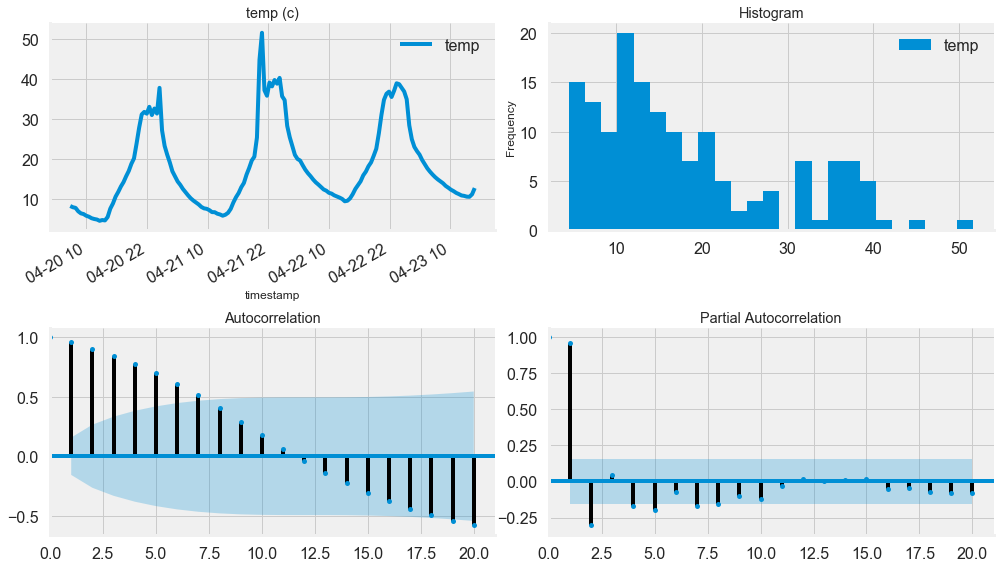

In [54]:
tsplot(temp_ts, title='temp (c)', lags = 20)

** Observation **

* Potential daily seasonality
* ACF tails off after 6 or 6 lags
* PACF tails off immediately
* Potentially there are both AR and MA component in the series

** Exam the deseason time series **

* Daily seasonality
* 30 mins is the interval total of 48 data points per season

In [55]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

In [56]:
diff_temp_ts = difference(temp_ts['temp'], interval=48)

(<matplotlib.axes._subplots.AxesSubplot at 0x1190fb250>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11b8f5b50>)

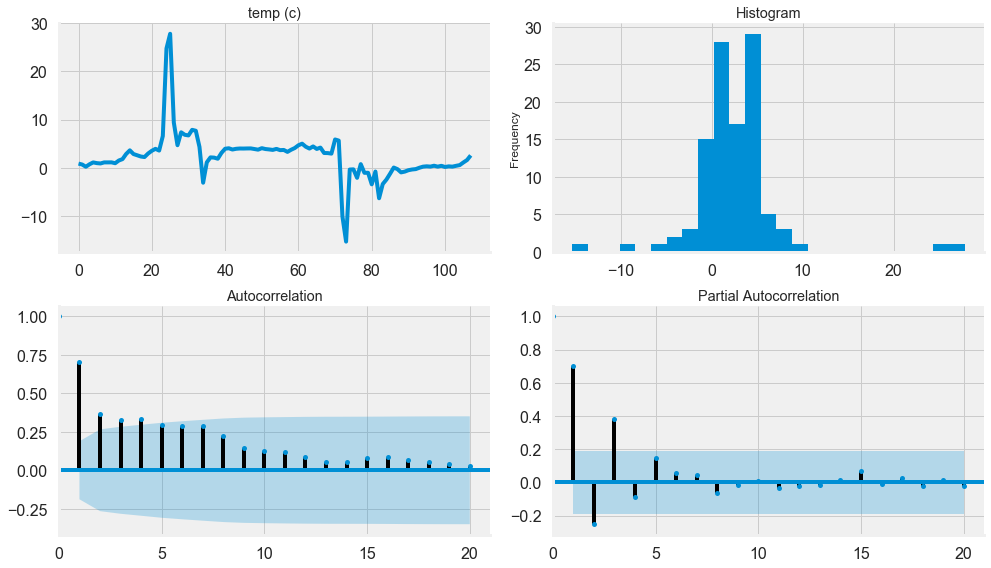

In [57]:
tsplot(diff_temp_ts, title='temp (c)', lags = 20)

** Observation **

* After remove the seasonality assumption, the distribution become more normal
* Without seasonality, both ACF and PACF drop quickly
* Possition degree can be AR(3) and MA(4)

Based on the observation of the difference transformation, we can test a model 

Such as: $SRARIMA (2, 0, 4) (0, 0, 0, 48)$

### Check stationality

** Notion of Stationarity: **


* A time series ${x_t}$ is said to be $\textit{strictly stationary}$ if the joint distributions $F(x_{t_1}, \dots, x_{t_n})$ and $F( x_{t_1+m}, \dots, x_{t_n +m})$ are the same, $\forall$ $t_1, ... t_n$ and $m$. This is a very strong condition, too strong to be applied in practice; it implies that the distribution is unchanged for any time shift!

* A weaker and more practical stationarity condition is that of $\textit{weakly stationary}$ (or $\textit{second order stationarity}$). A time series $x_t$ is said to be $\textit{weakly stationary}$ if it is mean and variance stationary and its autocovariance $Cov(x_t,x_{t+k})$ depends only the time displacement $k$ and can be written as $\gamma(k)$. 

* If a time series is __second order stationary__, then once a distribution assumption, such as normality, is imposed, the series can be completely characterized by its mean and covariance structure.


** Run Dick-Fuller Test to check whether series is second order stationary so we can apply ARIMA property **

In [68]:
def test_stationarity(timeseries,
                      maxlag=None, regression=None, autolag=None,
                      window=None, plot=False, verbose=False):
    '''
    Check unit root stationarity of time series.
    
    Null hypothesis: the series is non-stationary.
    If p >= alpha, the series is non-stationary.
    If p < alpha, reject the null hypothesis (has unit root stationarity).
    
    Original source: http://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
    
    Function: http://statsmodels.sourceforge.net/devel/generated/statsmodels.tsa.stattools.adfuller.html
    
    window argument is only required for plotting rolling functions. Default=4.
    '''
    
    # set defaults (from function page)
    if regression is None:
        regression = 'c'
    
    if verbose:
        print('Running Augmented Dickey-Fuller test with paramters:')
        print('maxlag: {}'.format(maxlag))
        print('regression: {}'.format(regression))
        print('autolag: {}'.format(autolag))
    
    if plot:
        if window is None:
            window = 4
        #Determing rolling statistics
        rolmean = timeseries.rolling(window=window, center=False).mean()
        rolstd = timeseries.rolling(window=window, center=False).std()
        
        #Plot rolling statistics:
        plt.figure(figsize=(12, 6))
        orig = plt.plot(timeseries, color='blue', label='Original')
        mean = plt.plot(rolmean, color='red', label='Rolling Mean ({})'.format(window))
        std = plt.plot(rolstd, color='black', label='Rolling Std ({})'.format(window))
        plt.legend(loc='best')
        plt.title('Rolling Mean & Standard Deviation')
        plt.show(block=False)
    
    #Perform Augmented Dickey-Fuller test:
    dftest = smt.adfuller(timeseries, maxlag=maxlag, regression=regression, autolag=autolag)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic',
                                             'p-value',
                                             '#Lags Used',
                                             'Number of Observations Used',
                                            ])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    if verbose:
        print('Results of Augmented Dickey-Fuller Test:')
        print(dfoutput)
    return dfoutput

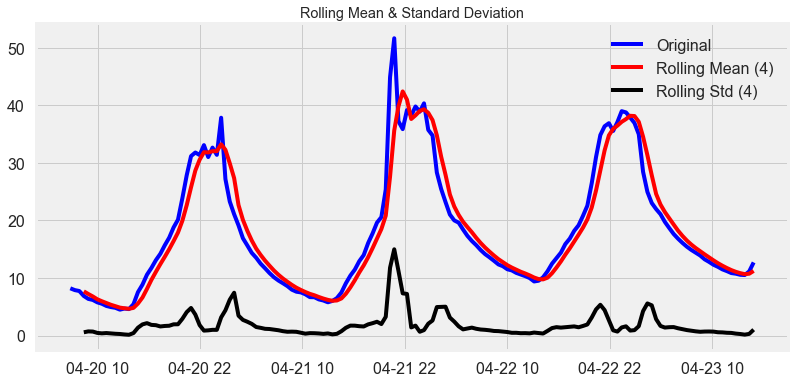

Test Statistic                  -3.454854
p-value                          0.009225
#Lags Used                      14.000000
Number of Observations Used    141.000000
Critical Value (5%)             -2.882266
Critical Value (1%)             -3.477601
Critical Value (10%)            -2.577822
dtype: float64

In [70]:
test_stationarity(temp_ts.temp, plot = True)

** Obseration **

Based on Dicker-fuller test, P-value < 0.05 indicate that the series is stationary.

### Try model $SRARIMA (2, 0, 4) (0, 0, 0, 48)$ 

In [220]:
# Create a training sample and testing sample before analyzing the series
n_sample = temp_ts.shape[0]

n_train=int(0.85*n_sample)+1
n_forecast=n_sample-n_train

#ts_df
ts_train = temp_ts.iloc[:n_train]['temp']
ts_test = temp_ts.iloc[n_train:]['temp']
print(ts_train.shape)
print(ts_test.shape)
print("Training Series:", "\n", ts_train.tail(), "\n")
print("Testing Series:", "\n", ts_test.head())

(133,)
(23,)
Training Series: 
 timestamp
2018-04-23 00:54:11    36.93
2018-04-23 01:24:14    34.98
2018-04-23 01:54:29    28.46
2018-04-23 02:24:57    24.97
2018-04-23 02:55:33    23.03
Name: temp, dtype: float64 

Testing Series: 
 timestamp
2018-04-23 03:26:15    21.98
2018-04-23 03:56:58    21.09
2018-04-23 04:27:45    19.75
2018-04-23 04:58:36    18.68
2018-04-23 05:29:30    17.65
Name: temp, dtype: float64


In [170]:
#Model Estimation

# Fit the model
sarima_test = sm.tsa.SARIMAX(np.array(ts_train), order=(2,0,4), seasonal_order=(0,0,0,48), simple_differencing=True)
model_results = sarima_test.fit()
model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  133
Model:               SARIMAX(2, 0, 4)   Log Likelihood                -323.858
Date:                Thu, 26 Apr 2018   AIC                            661.716
Time:                        18:59:48   BIC                            681.949
Sample:                             0   HQIC                           669.938
                                - 133                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.8107      0.145     12.502      0.000       1.527       2.095
ar.L2         -0.8218      0.147     -5.585      0.000      -1.110      -0.533
ma.L1         -0.5716      0.166     -3.447      0.001      -0.897      -0.247
ma.L2         -0.3262      0.065     -5.005      0.000      -0.454      -0.198
ma.L3          0.0749      0.120      0.623      0.533      -0.161       0.310
ma.L4          0.3075      0.091      3.378      0.001       0.129       0.486
sigma2         7.3512      0.330     22.254      0.000       6.704       7.999
===================================================================================
Ljung-Box (Q):                       25.00   Jarque-Bera (JB):              1959.62
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.34   Skew:                             0.67
Prob(H) (two-sided):                  0.00   Kurtosis:                        21.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

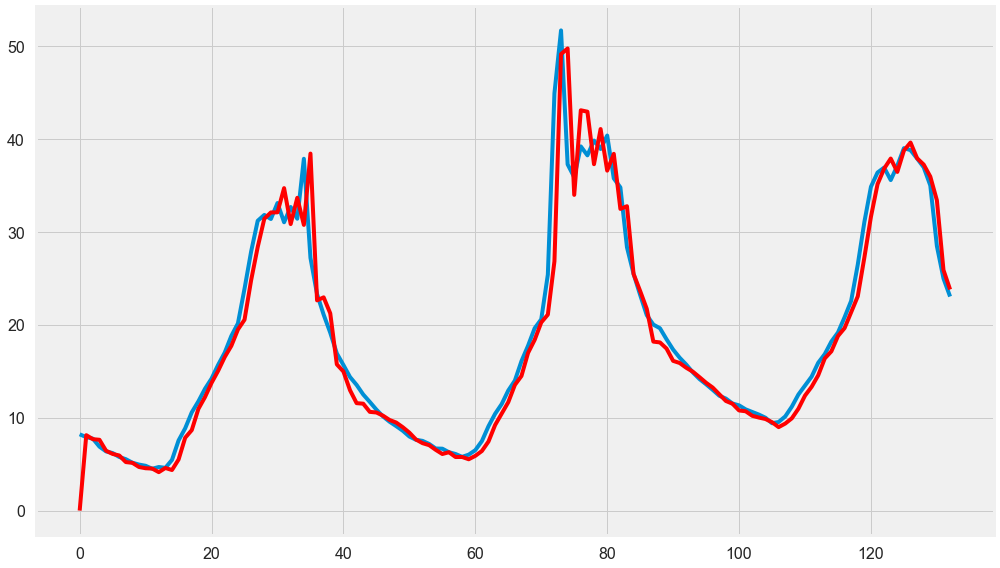

In [146]:
fig = plt.figure(figsize=(14,8))
plt.plot(ts_train)
plt.plot(model_results.fittedvalues, color = 'red')
fig.tight_layout()

** Observation **

In sample model predict looks quite reasonable

#### Model Diagnostic

* Conduct visual inspection of the residual plots
* Residuals of a well-specified ARIMA model should mimic *Gaussian white noises*: the residuals should be uncorrelated and distributed approximated normally with mean zero and variance $n^{-1}$

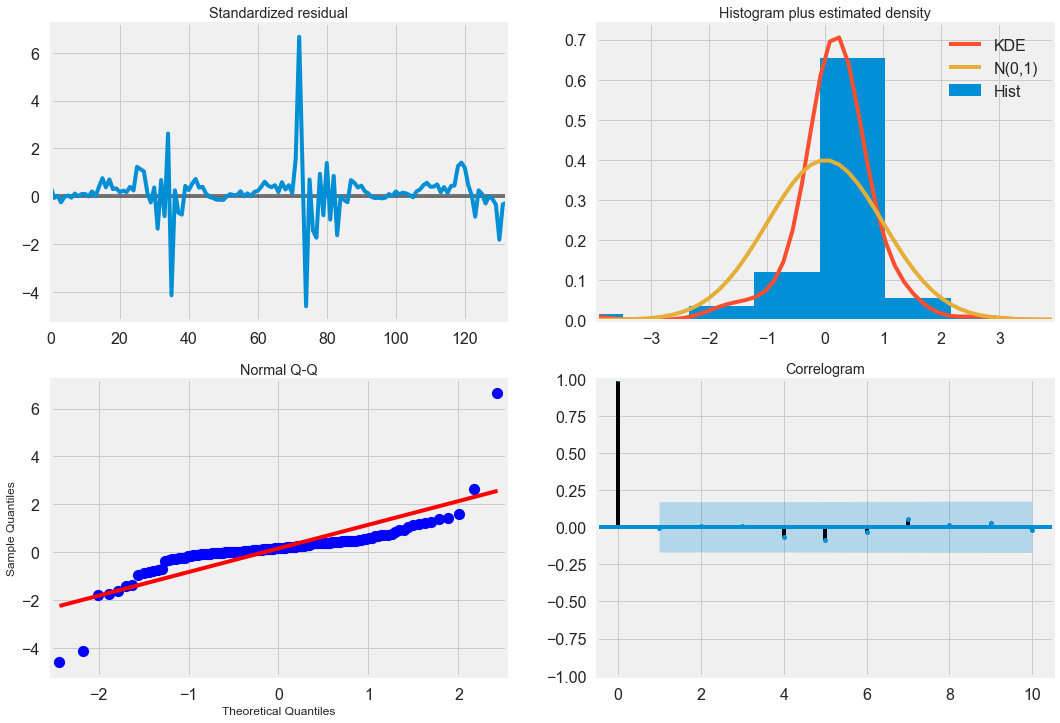

In [147]:
# Residual Diagnostics
# The plot_diagnostics function associated with the estimated result object produce a few plots that allow us 
# to examine the distribution and correlation of the estimated residuals
model_results.plot_diagnostics(figsize=(16, 12));

** Observation **

* The residual is close to normally distributed the skew to the right 
* There is no correlation between residuals, it is close to be a while noise
* This is an indication that our model is reasonable

#### Model Testing

* Test of heteroskedasticity

    * http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_heteroskedasticity.html#statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_heteroskedasticity

    * https://en.wikipedia.org/wiki/Heteroscedasticity

* Test normality (Jarque-bera)
    * http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_normality.html#statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_normality
   
* Test of serial correlation (Ljung-Box)
    * http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_serial_correlation.html#statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_serial_correlation

In [148]:
het_method='breakvar'
norm_method='jarquebera'
sercor_method='ljungbox'

(het_stat, het_p) = model_results.test_heteroskedasticity(het_method)[0]
norm_stat, norm_p, skew, kurtosis = model_results.test_normality(norm_method)[0]
sercor_stat, sercor_p = model_results.test_serial_correlation(method=sercor_method)[0]
sercor_stat = sercor_stat[-1] # last number for the largest lag
sercor_p = sercor_p[-1] # last number for the largest lag

print('Test heteroskedasticity of residuals ({}): stat={:.3f}, p={:.3f}'.format(het_method, het_stat, het_p));
print('\nTest normality of residuals ({}): stat={:.3f}, p={:.3f}'.format(norm_method, norm_stat, norm_p));
print('\nTest serial correlation of residuals ({}): stat={:.3f}, p={:.3f}'.format(sercor_method, sercor_stat, sercor_p));

Test heteroskedasticity of residuals (breakvar): stat=0.338, p=0.000

Test normality of residuals (jarquebera): stat=1959.621, p=0.000

Test serial correlation of residuals (ljungbox): stat=24.996, p=0.969


** Observation **

* Heteroskedasticity test (P value < 0.05) shows we can reject that there is no heterskedasticity
* Normality test (P value < 0.05) shows that we can reject that it is normality distributed
* Serial correlation (P value > 0.05) shows that we cannot reject that it is not series correlation

** Test whether residual is stationary **

In [149]:
# Run Durbin-Watson test on the standardized residuals.
# The statistic is approximately equal to 2*(1-r), where r is the sample autocorrelation of the residuals.
# Thus, for r == 0, indicating no serial correlation, the test statistic equals 2.
# This statistic will always be between 0 and 4. The closer to 0 the statistic,
# the more evidence for positive serial correlation. The closer to 4,
# the more evidence for negative serial correlation.
# Essentially, below 1 or above 3 is bad.
dw = sm.stats.stattools.durbin_watson(model_results.filter_results.standardized_forecasts_error[0, model_results.loglikelihood_burn:])

# check whether roots are outside the unit circle (we want them to be);
# will be True when AR is not used (i.e., AR order = 0)
arroots_outside_unit_circle = np.all(np.abs(model_results.arroots) > 1)
# will be True when MA is not used (i.e., MA order = 0)
maroots_outside_unit_circle = np.all(np.abs(model_results.maroots) > 1)

print('\nTest for all AR roots outside unit circle (>1): {}'.format(arroots_outside_unit_circle))
print('\nTest for all MA roots outside unit circle (>1): {}'.format(maroots_outside_unit_circle))


Test for all AR roots outside unit circle (>1): True

Test for all MA roots outside unit circle (>1): True


** Observation **

Yes the residual is stationary

#### Model performance evaluation (in sample fit)

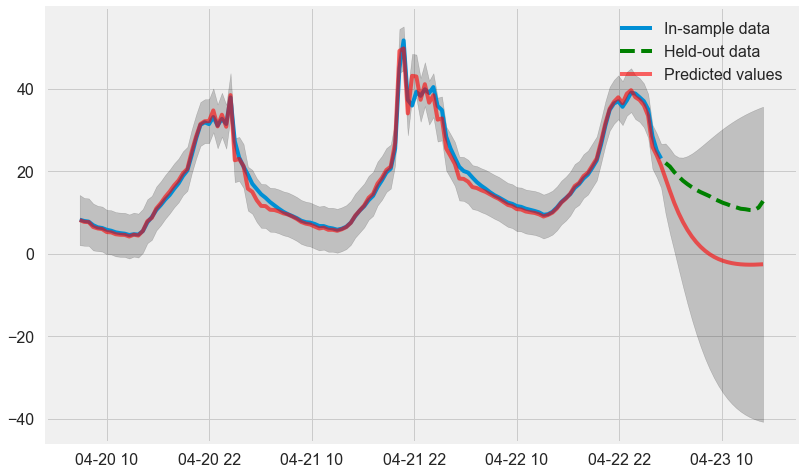

In [210]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
    
ax1.plot(ts_train, label='In-sample data', linestyle='-')
# subtract 1 only to connect it to previous point in the graph
ax1.plot(ts_test,  label='Held-out data', linestyle='--', color='g')

pred = model_results.get_prediction(start=0, end=156)
pred_mean = pred.predicted_mean
pred_mean = pd.DataFrame(data = np.array(pred_mean)[1:], index=temp_ts.index)
pred_ci = pred.conf_int(alpha=0.05)
pred_ci = pd.DataFrame(data = np.array(pred_ci)[1:], index=temp_ts.index)

ax1.plot(pred_mean, 'r', alpha=.6, label='Predicted values')
ax1.fill_between(pred_ci.index,
                 pred_ci.iloc[:, 0],
                 pred_ci.iloc[:, 1], color='k', alpha=.2)

ax1.legend(loc='best');

** Observation **

The insample prediction looks reasonable, the outsample prediction is quite poor for this model

** Measure Preformace **

* RMSE
* MAPE
* MASE

In [211]:
def get_rmse(y, y_hat):
    '''Root Mean Square Error
    https://en.wikipedia.org/wiki/Root-mean-square_deviation
    '''
    mse = np.mean((y - y_hat)**2)
    return np.sqrt(mse)

def get_mape(y, y_hat):
    '''Mean Absolute Percent Error
    https://en.wikipedia.org/wiki/Mean_absolute_percentage_error
    '''
    perc_err = (100*(y - y_hat))/y
    return np.mean(abs(perc_err))

def get_mase(y, y_hat):
    '''Mean Absolute Scaled Error
    https://en.wikipedia.org/wiki/Mean_absolute_scaled_error
    '''
    abs_err = abs(y - y_hat)
    dsum=sum(abs(y[1:] - y_hat[1:]))
    t = len(y)
    denom = (1/(t - 1))* dsum
    return np.mean(abs_err/denom)

In [226]:
get_rmse(np.array(ts_train), np.array(pred_mean.loc[ts_train.index]))

16.20427701739966

** Insample performance **

In [238]:
rmse = get_rmse(ts_train, pred_mean.loc[ts_train.index][0])
print("RMSE: ", rmse)

mape = get_mape(ts_train, pred_mean.loc[ts_train.index][0])
print("MAPE: ", mape)

mase = get_mase(ts_train, pred_mean.loc[ts_train.index][0])
print("MASE: ", mase)

RMSE:  1.4254536984861743
MAPE:  5.088328464136086
MASE:  0.9932361717401724


** Prediction performance **

In [237]:
rmse = get_rmse(ts_test, pred_mean.loc[ts_test.index][0])
print("RMSE: ", rmse)

mape = get_mape(ts_test, pred_mean.loc[ts_test.index][0])
print("MAPE: ", mape)

mase = get_mase(ts_test, pred_mean.loc[ts_test.index][0])
print("MASE: ", mase)

RMSE:  12.472607197160288
MAPE:  92.58760201381914
MASE:  0.969606593484337


** Observation **

Outsample prediction is match worse than in sample prediction for this error. RMSE at 12.47 is quite large base on our data. 

### Grid Search for the best SARIMA model